In [1]:
from fastai.vision.all import *
from pathlib import Path
import timm
import re
import pandas as pd
from skimage.color import gray2rgb
import dask.array as da
from tifffile import imread
from fastai.learner import load_learner
import numpy as np

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_atto_rms',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnext_zepto_rms',
 'convnext_zepto_rms_ols',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [ ]:
path = r'/mnt/d/data_analysis/2025_Birder_mito/images_mito'

pat = re.compile(r'^([^_]+)_\d{6}\.tif$')

def label_func(o):
    o = Path(o)
    match = pat.match(o.name)
    assert match, f'Pattern failed on {o.name}'
    label = match.group(1)
    return label #"discard" if label == "discard" else "mito"

dls = ImageDataLoaders.from_name_func(
    path,
    get_image_files(path),
    valid_pct=0.2,
    seed=42,
    label_func=label_func,
    item_tfms=[FlipItem(p=1.)],
    bs=16
)

In [5]:
dls.vocab

['discard', 'healthy', 'swollen']

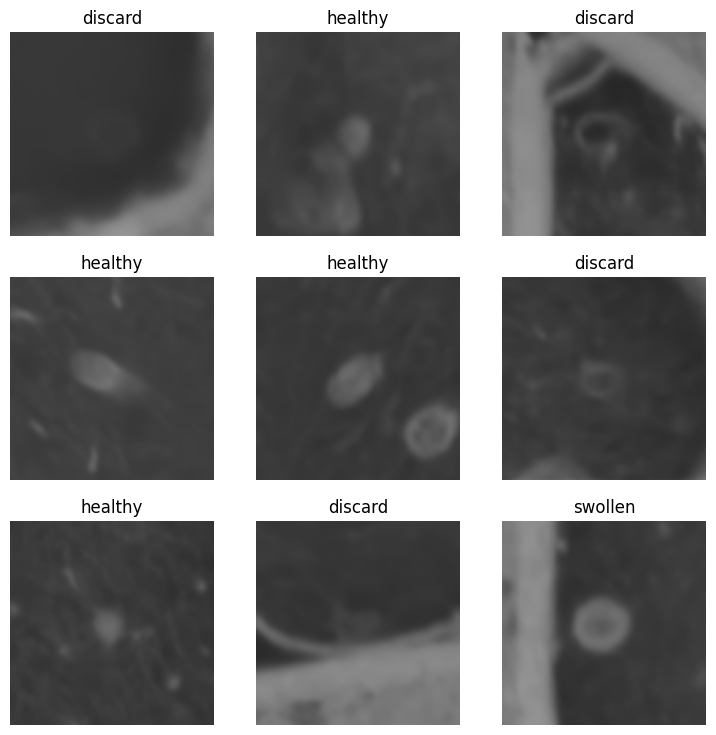

In [6]:
dls.show_batch(max_n=9)

In [7]:
learn = vision_learner(dls, 'convnext_tiny.fb_in22k', metrics=error_rate, model_dir=Path.home() / '.fastai' / 'models').to_fp16()

/home/kasia/miniforge3/envs/fastai-env/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/kasia/miniforge3/envs/fastai-env/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


SuggestedLRs(valley=0.0012022644514217973, slide=0.0008317637839354575)

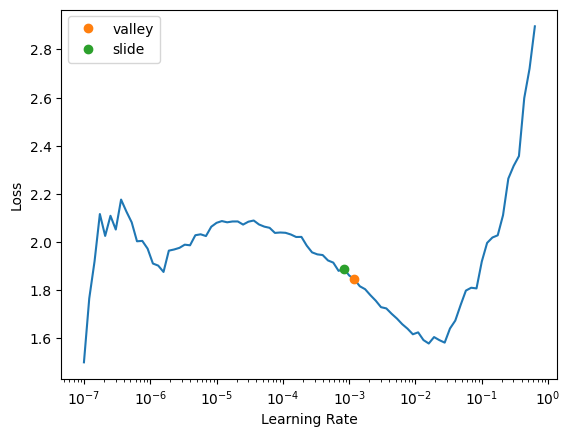

In [8]:
learn.lr_find(suggest_funcs=(valley, slide))

In [9]:
learn.fine_tune(20, 0.005)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.813751,1.208630,0.342105,00:04
1,0.673243,0.965100,0.298246,00:04
2,0.529878,1.026511,0.298246,00:04
3,0.472312,1.355399,0.394737,00:04
4,0.432302,1.268324,0.315789,00:05
5,0.381813,1.003203,0.315789,00:04
6,0.321620,1.394960,0.298246,00:04
7,0.329322,1.484384,0.359649,00:04
8,0.298131,1.384122,0.298246,00:04
9,0.242389,1.167950,0.289474,00:04


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

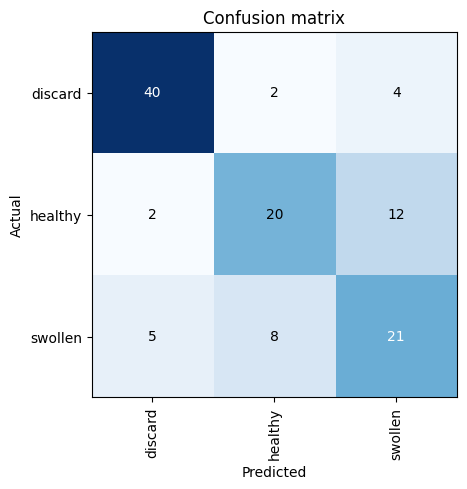

In [11]:
interp.plot_confusion_matrix()

/home/kasia/miniforge3/envs/fastai-env/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/kasia/miniforge3/envs/fastai-env/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


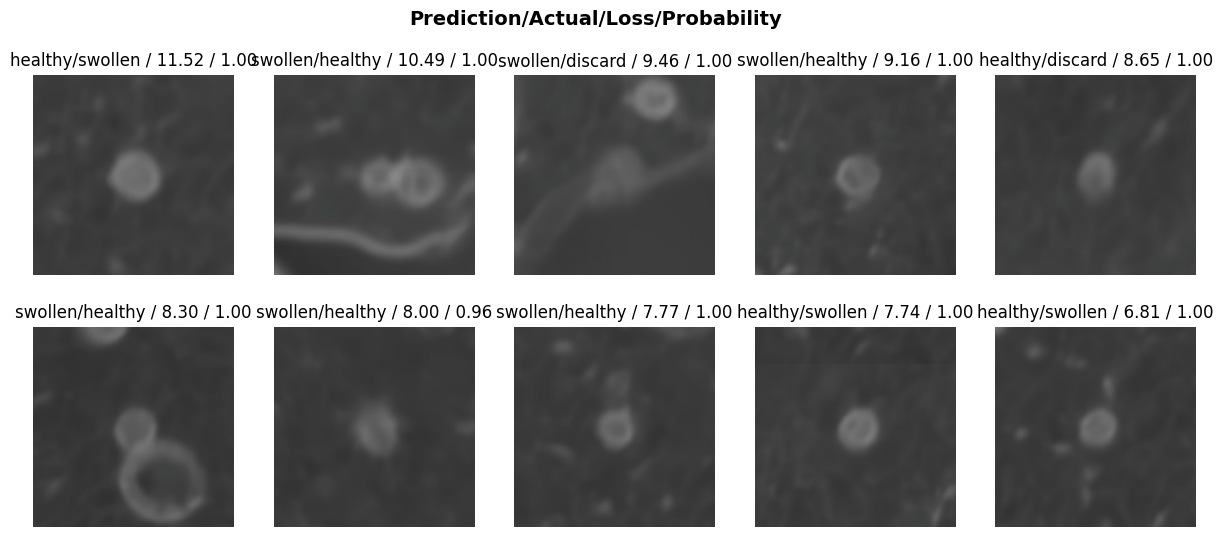

In [12]:
interp.plot_top_losses(10, nrows=2)

In [13]:
from pathlib import Path
learn.path = Path('/mnt/d/data_analysis/2025_Birder_mito')
learn.export(Path(r'250416_classifier.pkl'))

In [14]:
learn = load_learner('/mnt/d/data_analysis/2025_Birder_mito/250416_classifier.pkl')

/home/kasia/miniforge3/envs/fastai-env/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


# Classify all objects

In [17]:
df_path = r'/mnt/d/data_analysis/2025_Birder_mito/88EM87C_sample_center_mitos.pkl'
df_mitos = pd.read_pickle(df_path)

im_path = r'/mnt/d/data_analysis/2025_Birder_mito/88EM87C 25x25_ashlar.ome.tif'
# read in the image
store = imread(im_path, aszarr=True)
im = da.from_zarr(store,0)

In [ ]:
pad = 50

df_mitos['prediction_prob'] = None
df_mitos['prediction_prob'] = df_mitos['prediction_prob'].astype(object)

for ind,row in df_mitos.iterrows():

    row_start = int(row['centroid-0'] - pad)
    row_stop = int(row['centroid-0'] + pad)
    col_start = int(row['centroid-1'] - pad)
    col_stop = int(row['centroid-1'] + pad)

    im_mito = gray2rgb(im[row_start:row_stop, col_start:col_stop]).compute()

    cat,_,probs = learn.predict(im_mito)
    df_mitos.loc[ind,'prediction'] = str(cat)
    df_mitos.at[ind,'prediction_prob'] = np.array(probs)

    df_mitos['prediction_prob'] = df_mitos['prediction_prob'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
    
df_mitos.to_pickle(df_path)

/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


/tmp/ipykernel_764/631801381.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  df_mitos.at[ind,'prediction_prob'] = np.array(probs)


In [24]:
df_mitos

,index,area,bbox,predicted_iou,point_coords,stability_score,crop_box,origin,sc_area,area_convex,...,solidity,centroid-0,centroid-1,major_axis_length,minor_axis_length,keep,cell_label,label,annotation,prediction
0,0,231,"[64.0, 274.0, 18.0, 15.0]",0.921875,"[[67.84375, 287.65625]]",0.982759,"[0.0, 136.0, 167.0, 211.0]",18,218.0,224.0,...,0.973214,14065.655963,23056.532110,19.092409,14.741531,1,1,1,discard,discard
1,1,267,"[117.0, 377.0, 17.0, 18.0]",0.957031,"[[120.03125, 384.09375]]",0.959559,"[0.0, 272.0, 167.0, 211.0]",21,257.0,264.0,...,0.973485,14169.914397,23108.863813,19.285893,17.021795,1,1,2,swollen,swollen
2,2,419,"[80.0, 409.0, 19.0, 26.0]",0.917969,"[[88.71875, 423.65625]]",0.930023,"[0.0, 272.0, 167.0, 211.0]",22,408.0,416.0,...,0.980769,14205.593137,23072.877451,28.312462,18.421693,1,1,3,discard,discard
3,3,298,"[180.0, 286.0, 20.0, 18.0]",0.894531,"[[191.15625, 300.84375]]",0.935691,"[92.0, 136.0, 167.0, 211.0]",31,293.0,300.0,...,0.976667,14079.116041,23173.607509,20.425685,18.361238,1,1,4,discard,discard
4,4,535,"[209.0, 412.0, 29.0, 31.0]",0.875000,"[[232.90625, 423.65625]]",0.936709,"[92.0, 272.0, 167.0, 211.0]",38,528.0,666.0,...,0.792793,14210.611742,23209.719697,35.540453,23.306156,1,1,5,swollen,swollen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,6,289,"[238.0, 250.0, 18.0, 20.0]",0.957031,"[[256.125, 259.875]]",0.955631,"[117.0, 0.0, 212.0, 308.0]",19,285.0,295.0,...,0.966102,11963.540351,23654.828070,20.669515,17.628283,1,84,597,healthy,healthy
597,7,380,"[307.0, 604.0, 20.0, 22.0]",0.968750,"[[320.125, 608.875]]",0.978947,"[234.0, 426.0, 212.0, 308.0]",28,372.0,381.0,...,0.976378,12318.604839,23724.747312,23.156551,20.490656,1,84,598,healthy,healthy
598,0,539,"[55.0, 119.0, 29.0, 25.0]",0.953125,"[[64.53125, 122.71875]]",0.938849,"[0.0, 0.0, 118.0, 374.0]",4,522.0,549.0,...,0.950820,13010.821839,16095.245211,29.913726,22.693144,1,85,599,None,healthy
599,3,473,"[117.0, 363.0, 25.0, 23.0]",0.949219,"[[137.28125, 366.59375]]",0.964583,"[58.0, 314.0, 118.0, 374.0]",15,462.0,472.0,...,0.978814,13253.298701,16154.025974,27.147339,22.090117,1,85,600,None,swollen
